# **SkillCorner Example ETL Notebook**

This notebook demonstrates an end-to-end ETL process using open data from the **SkillCorner GitHub repository**.  
It ingests, structures, explores, and analyses football tracking and event data to produce performance metrics for players and teams.

---

### **Purpose**

This notebook provides a self-contained example of how to:
1. **Ingest** data from the SkillCorner public GitHub repository.  
2. **Store** raw data locally and structure it into Parquet tables.  
3. **Validate** and explore data consistency and quality.  
4. **Derive** metrics from the Dynamic Events dataset (e.g. sprints, passes, shots).  
5. **Aggregate** results at both player and team level for analysis and visualisation.

---

### **Execution Environment**

- Designed to run fully within **Google Colab**.  
- All code, logic, and outputs are contained within this notebook.  
- Data is stored locally within the Colab session (`/content/data`) and not persisted externally.  
- Suitable for small-scale exploration and demonstration only.

In a production environment:
- Data would be persisted in cloud storage (e.g. AWS S3, Azure Data Lake).  
- Orchestration would be handled by tools like **Airflow**, **Dagster**, or **Databricks Jobs**.  
- Code would be modularised into separate ingestion, transformation, and aggregation modules.  
- Scalable compute provided via **Spark** or **Databricks** clusters.
- Logging would be written to a monitoring system instead of printed inline, enabling observability and alerting across pipelines.  

### **Scope**

This example focuses on the **Raw → Bronze → Gold** stages of the data pipeline.  
The **Silver layer** (intermediate, cleaned, or conformed tables) has been skipped to keep the example concise.  
Only a subset of aggregated metrics are produced as the underlying datasets are large, wide, and time-consuming to process in full.


_Note: Parts of this notebook's documentation were generated with the assistance of AI._

## PySpark install for Colab instance
This section installs Java and PySpark, then configures environment variables for the Colab session.


In [1]:
# --- Install dependencies ---
!apt-get install -qq openjdk-17-jdk-headless
!pip install -q pyspark==4.0.1

import os
import importlib.util
from pyspark.sql import SparkSession

# --- Configure environment paths ---
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = os.path.dirname(importlib.util.find_spec("pyspark").origin)

# --- Initialise Spark session ---
spark = (
    SparkSession.builder
    .appName("SkillCorner_ETL")
    .master("local[*]")
    .getOrCreate()
)

print(f"PySpark {spark.version} initialised")
print(f"SPARK_HOME: {os.environ['SPARK_HOME']}")
print(f"JAVA_HOME: {os.environ['JAVA_HOME']}")

Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../openjdk-17-jre-headless_17.0.16+8~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jre-headless:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Selecting previously unselected package openjdk-17-jdk-headless:amd64.
Preparing to unpack .../openjdk-17-jdk-headless_17.0.16+8~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jdk-headless:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Setting up openjdk-17-jre-headless:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/jpackage to provide /usr/bin/jpackage (jpackage) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mod

## Library Imports

This section imports the libraries used throughout the notebook.  
In a production environment, these functions and utilities would typically be refactored into custom Python modules to improve maintainability, testing, and reusability across multiple pipelines. For example, creating reusable components for data ingestion, transformation, and validation.


In [2]:
# --- Standard Library ---
import os
import re
import json
import random
from pathlib import Path
from urllib.parse import urlparse
from typing import Optional, List, Dict, Any, Union, Tuple, TypedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- Third-Party Libraries ---
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from pyspark.sql import functions as F, types as T

# --- Data Analysis and Visualization ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### APIClient Class

The `APIClient` class is a reusable utility designed to streamline API-based data ingestion.  
It extends the functionality of Python's built-in `requests` library by providing:

- **Automatic retries** for transient network or server errors  
- **Parallel request execution** using a thread pool  
- **Flexible parameter handling**, including query, path, and JSON payloads  
- **Standardised response structure** for easier downstream processing  

This class is used throughout my data ingestion projects to simplify and standardise the way APIs are called when extracting data.


In [3]:
class RequestParams(TypedDict, total=False):
    """
    A dictionary specifying optional request components.

    Attributes:
        params (dict): Query parameters.
        data (dict): Form-encoded body.
        headers (dict): HTTP headers.
        json_payload (dict): JSON-encoded body.
        path_params (dict): Parameters to replace placeholders in endpoint URL.
    """
    params: Dict[str, Any]
    data: Dict[str, Any]
    headers: Dict[str, str]
    json_payload: Dict[str, Any]
    path_params: Dict[str, Any]

class APIClient:
    """
    A configurable HTTP client for making API requests with retry support,
    dynamic headers, and optional path parameter substitution.

    Supports both single and parallel requests using a thread pool.

    Args:
        base_url (str): Base API URL.
        retries (int): Number of retries on transient errors.
        backoff_factor (float): Time between retries (exponential backoff).
        status_forcelist (List[int]): HTTP statuses that trigger a retry.
        timeout (float or tuple): Timeout for each request (connect/read).
        default_headers (dict, optional): Headers applied to every request by default.
            These are merged with per-request headers, with per-request values taking precedence.
    """

    def __init__(self, base_url: str, retries: int = 5, backoff_factor: float = 1.0,
                 status_forcelist: Optional[List[int]] = None, timeout: Union[float, tuple] = (5, 30),
                 default_headers: Optional[Dict[str, str]] = None):
        self.base_url = base_url.rstrip("/")
        self.retries = retries
        self.backoff_factor = backoff_factor
        self.status_forcelist = status_forcelist or [429, 500, 502, 503, 504]
        self.timeout = timeout
        self.default_headers = default_headers or {}
        self.session = self._create_session()

    def __enter__(self):
        """Enable use of APIClient with a `with` statement."""
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Automatically close session on context exit."""
        self.close()

    def _create_session(self) -> requests.Session:
        """
        Creates a persistent requests.Session with retry behavior.

        Returns:
            requests.Session: A configured session.
        """
        session = requests.Session()
        retry = Retry(
            total=self.retries,
            read=self.retries,
            connect=self.retries,
            backoff_factor=self.backoff_factor * random.uniform(0.9, 1.2),
            status_forcelist=self.status_forcelist,
            allowed_methods=["HEAD", "GET", "OPTIONS", "POST", "PUT", "DELETE"]
        )
        adapter = HTTPAdapter(max_retries=retry)
        session.mount("http://", adapter)
        session.mount("https://", adapter)
        return session

    def _build_url(self, endpoint: str, path_params: Optional[Dict[str, Any]] = None) -> str:
        """
        Formats the endpoint with path parameters and builds the full URL.

        Args:
            endpoint (str): Endpoint with optional `{placeholder}` syntax.
            path_params (dict): Values to replace placeholders.

        Returns:
            str: Fully qualified URL.

        Raises:
            ValueError: If a placeholder is missing or unresolved.
        """
        if endpoint.startswith("http://") or endpoint.startswith("https://"):
            return endpoint

        endpoint = endpoint.lstrip("/")
        if path_params:
            try:
                endpoint = endpoint.format(**path_params)
            except KeyError as e:
                raise ValueError(f"Missing path parameter for placeholder: {e}")
        if re.search(r'{[^{}]+}', endpoint):
            raise ValueError(f"Unresolved placeholders in endpoint: {endpoint}")
        return f"{self.base_url}/{endpoint}"

    def _handle_response(self, response: requests.Response, params: Optional[Dict[str, Any]] = None, path_params: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
        """
        Handles and parses the API response, returning structured metadata.

        Args:
            response (requests.Response): HTTP response.
            params (dict, optional): Parameters used to construct the request URL.
            path_params (dict, optional): Path parameters used to construct the request URL.

        Returns:
            dict: Contains the parsed response and request metadata.
        """
        try:
            body = response.json()
        except ValueError:
            body = response.content

        request_info = {
            "url": response.url,
            "method": response.request.method,
            "headers": dict(response.request.headers),
            "body": response.request.body,
        }

        if params:
            request_info["params"] = params
        if path_params:
            request_info["path_params"] = path_params

        return {
            "response": body,
            "request": request_info,
        }


    def request(self, method: str, endpoint: str, params: Optional[Dict[str, Any]] = None,
                data: Optional[Dict[str, Any]] = None, headers: Optional[Dict[str, str]] = None,
                json_payload: Optional[Dict[str, Any]] = None,
                path_params: Optional[Dict[str, Any]] = None,
                timeout: Optional[Union[float, Tuple[float, float]]] = None) -> Union[Dict[str, Any], str]:
        """
        Sends a single HTTP request to the specified endpoint.

        Args:
            method (str): HTTP method (e.g., 'GET', 'POST').
            endpoint (str): Relative endpoint, can include `{placeholders}`.
            params (dict): URL query parameters.
            data (dict): Form-encoded POST body.
            headers (dict): Custom headers.
            json_payload (dict): JSON-encoded POST body.
            path_params (dict): Placeholder replacements for the endpoint.
            timeout (float or tuple): Timeout for each request (connect/read).

        Returns:
            dict or str: Parsed JSON or raw response text.

        Raises:
            HTTPError: For bad HTTP status responses.
            RequestException: For network-related issues.
        """
        url = self._build_url(endpoint, path_params)
        headers = {**self.default_headers, **(headers or {})}

        try:
            response = self.session.request(
                method=method.upper(),
                url=url,
                params=params,
                data=data,
                headers=headers,
                json=json_payload,
                timeout=timeout or self.timeout
            )
            response.raise_for_status()
            return self._handle_response(response, params=params, path_params=path_params)
        except requests.exceptions.HTTPError as http_err:
            raise requests.exceptions.HTTPError(f"HTTP error: {http_err} - Response: {response.text}") from http_err
        except requests.exceptions.RequestException as req_err:
            raise requests.exceptions.RequestException(f"Request error: {req_err}") from req_err

    def parallel_requests(self, requests_list: List[Tuple[str, str, RequestParams]], max_workers: int = 5) -> List[Any]:
        """
        Executes multiple API requests concurrently using threads.

        Args:
            requests_list (List[Tuple[str, str, RequestParams]]):
                Each tuple is (method, endpoint, params_dict) where `params_dict`
                can include any of: `params`, `data`, `headers`, `json_payload`, `path_params`.

            max_workers (int): Max threads to use concurrently.

        Returns:
            List[Any]: Each item is a response or error dictionary.
        """
        responses = []
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_request = {
                executor.submit(self.request, method, endpoint,
                                params=req.get("params"),
                                data=req.get("data"),
                                headers=req.get("headers"),
                                json_payload=req.get("json_payload"),
                                path_params=req.get("path_params")): (method, endpoint, req)
                for method, endpoint, req in requests_list
            }

            for future in as_completed(future_to_request):
                method, endpoint, req = future_to_request[future]
                try:
                    response = future.result()
                    responses.append(response)
                except Exception as exc:
                    responses.append({
                        "error": str(exc),
                        "request": {"method": method, "endpoint": endpoint, **req}
                    })

        return responses

    def close(self):
        """
        Closes the internal session to free up connections.
        """
        self.session.close()

## **Data Ingestion from GitHub**

This section contains functionality to extract data from the **SkillCorner public GitHub repository**, though it can easily be adapted to ingest from other public GitHub repositories if required.  
The modular ingestion logic includes the ability to:
- Inspect the repository's file structure  
- Identify files for download  
- Download them in parallel for improved efficiency  

It also handles **Git LFS pointer files**, which reference large binary objects stored externally, ensuring these are correctly resolved and downloaded from the appropriate endpoints.

Extracted data is saved in its **raw format** (CSV, JSON, etc.) to the Colab instance.  
In a production environment, this would instead be written to **cloud storage** (e.g., S3 or Azure Storage).  
Persisting the raw layer allows for quick re-loading into downstream Bronze tables if data schemas change, without re-downloading all source files.

For this notebook, a **full load** is executed each time for simplicity.  
In production, **incremental ingestion** would be implemented using metadata checkpoints to ingest only new or modified files (i.e., the delta).


In [4]:
# ------------------------------------------------
# COLLECT FILES FROM GITHUB REPOSITORY TREE
# ------------------------------------------------
def collect_github_files_tree(owner, repo, branch="master", folder=None, client=None):
    """Recursively retrieves file paths from a GitHub repo tree."""
    base_url = "https://api.github.com/repos"
    if client is None:
        client = APIClient(base_url)

    endpoint = f"{owner}/{repo}/git/trees/{branch}"
    github_response = client.request("GET", endpoint, params={"recursive": "1"}).get("response")

    file_api_calls = []
    for item in github_response.get("tree", []):
        # Skip folders; only process files
        if item.get("type") != "blob":
            continue

        path = item["path"]
        # Optionally filter to a specific folder
        if folder and not path.startswith(folder.rstrip("/") + "/"):
            continue

        # Construct raw GitHub URL
        raw_url = f"https://raw.githubusercontent.com/{owner}/{repo}/{branch}/{path}"
        file_api_calls.append(("GET", raw_url))
    return file_api_calls


# ------------------------------------------------
# DOWNLOAD A SINGLE FILE
# ------------------------------------------------
def download_single_file(client, raw_url, output_dir, owner, repo, branch):
    """Downloads an individual file (handles Git LFS pointers if required)."""
    url_parts = urlparse(raw_url).path.split("/", 5)
    path = url_parts[-1]
    save_path = os.path.join(output_dir, path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    resp = client.session.get(raw_url, timeout=client.timeout, stream=True)
    resp.raise_for_status()
    first_chunk = next(resp.iter_content(chunk_size=512), b"")

    # --- Handle Git LFS pointer files ---
    if first_chunk.startswith(b"version https://git-lfs.github.com/spec/v1"):
        pointer_text = first_chunk.decode("utf-8") + resp.text[len(first_chunk):]
        match = re.search(r"oid sha256:([a-f0-9]+)", pointer_text)
        if match:
            # Replace URL for LFS download
            media_url = raw_url.replace(
                "https://raw.githubusercontent.com/",
                "https://media.githubusercontent.com/media/",
            )
            lfs_resp = client.session.get(media_url, timeout=client.timeout, stream=True)
            lfs_resp.raise_for_status()
            with open(save_path, "wb") as f:
                for chunk in lfs_resp.iter_content(chunk_size=32768):
                    f.write(chunk)
            print(f"LFS file saved: {path}")
            return save_path
        print(f"Unparsed LFS pointer: {path}")
        return None

    # --- Save standard file content ---
    with open(save_path, "wb") as f:
        f.write(first_chunk)
        for chunk in resp.iter_content(chunk_size=32768):
            f.write(chunk)
    print(f"Saved: {path}")
    return save_path


# ------------------------------------------------
# PARALLEL DOWNLOAD OF FILES
# ------------------------------------------------
def download_github_files_fast(calls, client, output_dir, owner, repo, branch="master", max_workers=16):
    """Downloads multiple files concurrently using a thread pool."""
    os.makedirs(output_dir, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(download_single_file, client, url, output_dir, owner, repo, branch): url
            for _, url in calls
        }
        for future in as_completed(futures):
            try:
                future.result()
            except Exception as e:
                print(f"Error downloading {futures[future]}: {e}")


# ------------------------------------------------
# MAIN GITHUB INGESTION FUNCTION
# ------------------------------------------------
def run_github_ingestion(owner, repo, output_dir="data/raw", branch="master", folder="data", max_workers=16):
    """Main entry point for GitHub data ingestion."""
    client = APIClient("https://api.github.com/repos")

    # Collect all file paths from repo
    calls = collect_github_files_tree(owner, repo, branch=branch, folder=folder, client=client)
    print(f"Found {len(calls)} files")

    # Download in parallel
    download_github_files_fast(calls, client, output_dir, owner, repo, branch, max_workers)

    # Clean up session
    client.close()
    print("GitHub ingestion completed.")

In [6]:
# ------------------------------------------------
# EXECUTE GITHUB INGESTION (FULL DATA EXTRACT)
# ------------------------------------------------
run_github_ingestion(
    owner="SkillCorner",
    repo="opendata",
    branch="master",
    output_dir="/content/data/raw/skillcorner_github",
    folder="data",
    max_workers=10
)

Found 42 files
Saved: aggregates/aus1league_physicalaggregates_20242025_midfielders.csv
Saved: matches/1886347/1886347_match.json
Saved: matches.json
Saved: matches/1886347/1886347_phases_of_play.csv
Saved: matches/1899585/1899585_match.json
Saved: matches/1899585/1899585_phases_of_play.csv
Saved: matches/1925299/1925299_match.json
Saved: matches/1925299/1925299_phases_of_play.csv
Saved: matches/1953632/1953632_match.json
Saved: matches/1953632/1953632_phases_of_play.csv
Saved: matches/1996435/1996435_match.json
Saved: matches/1996435/1996435_phases_of_play.csv
Saved: matches/1886347/1886347_dynamic_events.csv
Saved: matches/1899585/1899585_dynamic_events.csv
Saved: matches/1925299/1925299_dynamic_events.csv
Saved: matches/2006229/2006229_match.json
Saved: matches/2006229/2006229_phases_of_play.csv
Saved: matches/1953632/1953632_dynamic_events.csv
Saved: matches/2011166/2011166_match.json
Saved: matches/1996435/1996435_dynamic_events.csv
Saved: matches/2011166/2011166_phases_of_play.cs

## **Bronze Table Creation**

This section defines the function `write_skillcorner_to_bronze`, which reads raw SkillCorner data and writes it into structured **Bronze-level** Parquet tables.  
These tables serve as the foundation for all subsequent transformations and aggregations.

Key features:
- Dynamically locates and reads raw files (CSV, JSON, or JSONL) from the local `/content/data/raw` directory  
- Automatically adds metadata fields such as `source_file` and `ingested_at`  
- Writes the structured data to the `/content/data/bronze` path in Parquet format  

In this notebook:
- All dataset loads are **full loads**, meaning data is fully re-ingested on each run for simplicity.  
  In production, only **incremental changes (deltas)** would be processed to improve efficiency.  

In a production environment:
- Data schemas would typically be stored in a **central repository or metadata registry**,  
  allowing schema definitions to be version-controlled and easily updated as data structures evolve.  
- This schema-driven approach ensures consistent typing, enables **schema evolution management**, and avoids issues caused by manual inference.  
- Bronze data would be persisted to **cloud storage** instead of local disk for scalability and durability.


In [7]:
# ------------------------------------------------
# BRONZE TABLE CREATION FUNCTION
# ------------------------------------------------
def write_skillcorner_to_bronze(dataset, file_type, base_data_dir="/content/data"):
    """
    Reads raw SkillCorner data from local storage and writes it to a structured
    'bronze' Parquet table.

    Parameters
    ----------
    dataset : str
        Dataset name (e.g., 'dynamic_events', 'match', etc.)
    file_type : str
        File type of source data ('csv', 'json', or 'jsonl')
    base_data_dir : str, optional
        Base data directory path. Defaults to '/content/data' (for Colab use).

    Notes
    -----
    - In this notebook, full loads are performed each time.
    - In production, incremental ingestion and schema versioning would be used.
    - Schema inference is performed dynamically when no predefined schema is available.
    """

    # --- Define input and output paths ---
    raw_root = Path(base_data_dir) / "raw" / "skillcorner_github"
    bronze_output_path = Path(base_data_dir) / "bronze" / f"skillcorner_{dataset}"

    # Determine which subfolder the dataset belongs to
    if dataset in ['dynamic_events', 'match', 'phases_of_play', 'tracking_extrapolated']:
        base_dir = raw_root / "matches"
        files = list(base_dir.glob(f"*/*_{dataset}*"))
    else:
        base_dir = raw_root / "aggregates"
        files = list(base_dir.glob(f"*_{dataset}*"))

    files_str = [str(f) for f in files]
    if not files_str:
        raise FileNotFoundError(f"No files found for dataset='{dataset}' in {base_dir}")

    # --- Read raw files into a Spark DataFrame ---
    if file_type == 'csv':
        raw_df = (
            spark.read
            .option("header", True)
            .option("inferSchema", True) # Schema would be imported in production
            .csv(files_str)
        )

    elif file_type in ('json', 'jsonl'):
        multiline = file_type == 'json'
        try:
            # Attempt to read schema from the first file
            schema = spark.read.option("multiline", multiline).json(files_str[0]).schema # Schema would be imported in production
        except ValueError:
            print(f"No predefined schema found for {dataset}, inferring schema dynamically.")
            schema = spark.read.option("multiline", multiline).json(files_str[0]).schema

        raw_df = (
            spark.read
            .option("multiline", multiline)
            .schema(schema)
            .json(files_str)
        )

    else:
        raise ValueError(f"Unsupported file_type: {file_type}")

    # --- Add ingestion metadata columns ---
    bronze_df = (
        raw_df
        .withColumn("source_file", F.input_file_name())
        .withColumn("ingested_at", F.current_timestamp().cast("string"))
    )

    print(f"Rows read for {dataset}: {bronze_df.count():,}")

    # --- Write to Parquet (Bronze layer) ---
    bronze_output_path.parent.mkdir(parents=True, exist_ok=True)
    bronze_df.write.mode("overwrite").parquet(str(bronze_output_path))
    print(f"Wrote Bronze table: {bronze_output_path}")

In [8]:
# ------------------------------------------------
# PARALLEL BRONZE INGESTION
# ------------------------------------------------

# List of datasets to ingest (dataset_name, file_type)
datasets = [
    ('dynamic_events', 'csv'),
    ('phases_of_play', 'csv'),
    ('physicalaggregates', 'csv'),
    ('match', 'json'),
    ('tracking_extrapolated', 'jsonl'),
]


def run_bronze_ingestion(dataset_tuple):
    """Helper function for running ingestion safely in parallel threads."""
    dataset, file_type = dataset_tuple
    try:
        write_skillcorner_to_bronze(dataset, file_type)
        return f"Completed: {dataset}"
    except Exception as e:
        return f"Failed: {dataset} | Error: {e}"


# Execute ingestions concurrently
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(run_bronze_ingestion, ds): ds for ds in datasets}
    for future in as_completed(futures):
        print(future.result())

Rows read for tracking_extrapolated: 642,687
Rows read for match: 10
Rows read for physicalaggregates: 406
Rows read for phases_of_play: 4,581
Rows read for dynamic_events: 47,853
Wrote Bronze table: /content/data/bronze/skillcorner_match
Completed: match
Wrote Bronze table: /content/data/bronze/skillcorner_tracking_extrapolated
Completed: tracking_extrapolated
Wrote Bronze table: /content/data/bronze/skillcorner_phases_of_play
Completed: phases_of_play
Wrote Bronze table: /content/data/bronze/skillcorner_physicalaggregates
Completed: physicalaggregates
Wrote Bronze table: /content/data/bronze/skillcorner_dynamic_events
Completed: dynamic_events


## **Bronze Table Loading and Exploratory Data Analysis (EDA)**

This section loads the **Bronze-level** Parquet tables created in the previous step for basic validation and exploratory analysis.  
The goal is to confirm data quality, schema consistency, and expected record counts before any downstream transformation or aggregation.

Key notes:
- In a production system, this stage would typically exist as its own **stand-alone notebook or script**, rather than within the ingestion pipeline.  
- Bronze tables would be **loaded from cloud storage** (e.g. S3 or ADLS), rather than from the local `/content/data` path used in this example.  
- The examples below demonstrate quick **data validation** and **schema inspection** — including record counts, column summaries, and key field distributions.  
- In this notebook, all data resides locally and can be reloaded directly from the generated Bronze Parquet files.

Typical checks performed here include:
- Row counts and schema validation across key datasets (matches, events, phases, tracking).  
- Distribution of event types and possession phases.  
- Basic summary statistics (durations, distances, team and player activity).  
- Cross-table validation to ensure dataset consistency (e.g. players in match files appear in events).


In [9]:
dynamic_events_bronze_df = spark.read.parquet("/content/data/bronze/skillcorner_dynamic_events")
phases_of_play_bronze_df = spark.read.parquet("/content/data/bronze/skillcorner_phases_of_play")
physicalaggregates_bronze_df = spark.read.parquet("/content/data/bronze/skillcorner_physicalaggregates")
match_bronze_df = spark.read.parquet("/content/data/bronze/skillcorner_match")
tracking_extrapolated_bronze_df = spark.read.parquet("/content/data/bronze/skillcorner_tracking_extrapolated")

In [10]:
# ------------------------------------------------
# GENERIC SUMMARY FUNCTIONS
# ------------------------------------------------
def describe_numeric_columns(df, cols):
    """Show basic statistics for numeric columns in a Spark DataFrame."""
    return df.select(*cols).describe().show()

def count_by_column(df, col, top_n=10):
    """Display top N value counts for a column."""
    (
        df.groupBy(col)
        .count()
        .orderBy(F.desc("count"))
        .show(top_n, truncate=False)
    )

def count_total(df, label):
    """Print total count with label."""
    print(f"{label}: {df.count():,}")

In [11]:
# ------------------------------------------------
# MATCHES
# ------------------------------------------------
print("=== MATCH SUMMARY ===")
count_total(match_bronze_df, "Matches")

# Sample of home and away teams
match_bronze_df.select("id", "home_team.name", "away_team.name").show(5, truncate=False)

# Pitch dimensions and player count summary
describe_numeric_columns(match_bronze_df, ["pitch_length", "pitch_width"])

# Player-related summary
print("\n=== MATCH PLAYER SUMMARY ===")

# Count players per match
match_bronze_df.select(F.size("players").alias("num_players")).describe().show()

# Extract and preview player details
match_players_df = (
    match_bronze_df
    .select(F.col("id").alias("match_id"), F.explode("players").alias("player"))
    .select(
        "match_id",
        F.col("player.id").alias("player_id"),
        F.col("player.short_name").alias("player_name"),
        F.col("player.playing_time.total.minutes_played").alias("minutes_played")
    )
)
print(f"Total players (unique): {match_players_df.select('player_id').distinct().count()}")
match_players_df.show(10, truncate=False)


=== MATCH SUMMARY ===
Matches: 10
+-------+-------------------------------+-------------------------------+
|id     |name                           |name                           |
+-------+-------------------------------+-------------------------------+
|2017461|Melbourne Victory Football Club|Auckland FC                    |
|2011166|Wellington Phoenix FC          |Melbourne Victory Football Club|
|1925299|Brisbane Roar FC               |Perth Glory Football Club      |
|2006229|Melbourne City FC              |Macarthur FC                   |
|2015213|Western United                 |Auckland FC                    |
+-------+-------------------------------+-------------------------------+
only showing top 5 rows
+-------+------------------+-----------+
|summary|      pitch_length|pitch_width|
+-------+------------------+-----------+
|  count|                10|         10|
|   mean|             105.0|       68.0|
| stddev|0.6666666666666652|        0.0|
|    min|               104|  

In [12]:
# ------------------------------------------------
# DYNAMIC EVENTS
# ------------------------------------------------
print("=== DYNAMIC EVENTS SUMMARY ===")
count_total(dynamic_events_bronze_df, "Dynamic events")

# Unique players
unique_players_dynamic = dynamic_events_bronze_df.select("player_id").distinct().count()
print(f"Unique players in dynamic events: {unique_players_dynamic:,}")

# Event types and player frequency
count_by_column(dynamic_events_bronze_df, "event_type")
count_by_column(dynamic_events_bronze_df, "player_name")

# Event duration summary
describe_numeric_columns(dynamic_events_bronze_df, ["duration"])

# Key event outcomes
dynamic_events_bronze_df.agg(
    F.sum(F.col("lead_to_shot").cast("int")).alias("events_leading_to_shot"),
    F.sum(F.col("lead_to_goal").cast("int")).alias("events_leading_to_goal")
).show()

# Event thirds
count_by_column(dynamic_events_bronze_df, "third_start")
count_by_column(dynamic_events_bronze_df, "third_end")


# ------------------------------------------------
# PHASES OF PLAY
# ------------------------------------------------
print("=== PHASES OF PLAY SUMMARY ===")
count_total(phases_of_play_bronze_df, "Phases of play")

# Phase type and duration
count_by_column(phases_of_play_bronze_df, "team_in_possession_phase_type")
describe_numeric_columns(phases_of_play_bronze_df, ["duration"])

# Outcomes: shots or goals
phases_of_play_bronze_df.agg(
    F.sum(F.col("team_possession_lead_to_shot").cast("int")).alias("phases_with_shot"),
    F.sum(F.col("team_possession_lead_to_goal").cast("int")).alias("phases_with_goal")
).show()

# Start and end thirds
count_by_column(phases_of_play_bronze_df, "third_start")
count_by_column(phases_of_play_bronze_df, "third_end")


=== DYNAMIC EVENTS SUMMARY ===
Dynamic events: 47,853
Unique players in dynamic events: 206
+------------------+-----+
|event_type        |count|
+------------------+-----+
|passing_option    |24374|
|player_possession |9566 |
|on_ball_engagement|8911 |
|off_ball_run      |5002 |
+------------------+-----+

+-------------+-----+
|player_name  |count|
+-------------+-----+
|G. May       |1002 |
|F. Gallegos  |968  |
|L. Rogerson  |834  |
|L. Verstraete|803  |
|J. Brimmer   |689  |
|K. Trewin    |689  |
|F. De Vries  |660  |
|A. Cáceres   |649  |
|D. Hall      |637  |
|N. Pijnaker  |630  |
+-------------+-----+
only showing top 10 rows
+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|             47853|
|   mean|1.3917643616910174|
| stddev|1.4255628588362865|
|    min|               0.0|
|    max|              23.5|
+-------+------------------+

+----------------------+----------------------+
|events_leading_to_shot|events_leading_to_goal|


In [13]:
# ------------------------------------------------
# PLAYER VALIDATION ACROSS TABLES
# ------------------------------------------------
print("=== PLAYER VALIDATION ===")

# --- Extract players from match metadata ---
match_players = (
    match_bronze_df
    .select(F.explode("players").alias("player"))
    .select(
        F.col("player.id").alias("player_id"),
        F.col("player.playing_time.total.minutes_played").alias("minutes_played")
    )
    .filter(F.col("minutes_played").isNotNull())   # exclude null minutes, some players don't have tracking or events as they did not play
    .dropDuplicates(["player_id"])                 # ensure unique players
)

# --- Distinct player sets from other tables ---
tracking_players = match_players.select("player_id").distinct()
event_players = dynamic_events_bronze_df.select("player_id").distinct()

# --- Counts ---
count_total(match_players, "Players in match metadata")
count_total(tracking_players, "Players in tracking data")
count_total(event_players, "Players in dynamic events")

# --- Missing players ---
missing_from_tracking = match_players.join(tracking_players, "player_id", "left_anti")
missing_from_events = match_players.join(event_players, "player_id", "left_anti")

count_total(missing_from_tracking, "Players missing from tracking")
count_total(missing_from_events, "Players missing from dynamic events")


=== PLAYER VALIDATION ===
Players in match metadata: 206
Players in tracking data: 206
Players in dynamic events: 206
Players missing from tracking: 0
Players missing from dynamic events: 0


### **Optional: YData Profiling Summary**

This section generates data profiling reports using the **YData Profiling** library.  
While not specifically optimised for **Spark** or **nested JSON structures**, it provides a convenient way to quickly review the structure, distributions, and potential data quality issues within each dataset.

The profiling process converts each Spark DataFrame into a smaller **Pandas sample**, making it more suitable for lightweight inspection in this environment.  

Although not a production-grade validation tool, YData Profiling offers a useful **visual summary** for exploratory analysis and is something I often use to quickly *eyeball* data completeness and schema consistency before proceeding with transformations.

In a **production environment**, this step would typically be replaced or complemented by **data validation frameworks** such as *Great Expectations* to ensure automated and repeatable data quality checks.


In [ ]:
!pip install -q ydata-profiling

from ydata_profiling import ProfileReport

def generate_profile_report(spark_df, dataset_name, output_dir="/content/output/data_profiling"):
    """
    Generate a YData Profiling HTML report from a Spark DataFrame.

    Converts the Spark DataFrame to Pandas (sampling if large) and saves
    a minimal profiling report for quick exploration.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / f"{dataset_name}_profile.html"

    print(f"Generating profile report for: {dataset_name}...")

    # Convert to Pandas (sample if too large for memory)
    pdf = spark_df.limit(50000).toPandas()

    profile = ProfileReport(
        pdf,
        title=f"SkillCorner {dataset_name.capitalize()} Profiling Report",
        explorative=True,
        minimal=True
    )

    profile.to_file(output_file)
    print(f"Profiling report saved to: {output_file}")


# Example usage
bronze_datasets = {
    "dynamic_events": dynamic_events_bronze_df,
    "phases_of_play": phases_of_play_bronze_df,
    "match": match_bronze_df,
    # "tracking_extrapolated": tracking_extrapolated_bronze_df, # Commenting out due to size
    # "physicalaggregates": physicalaggregates_bronze_df
}

for name, df in bronze_datasets.items():
    generate_profile_report(df, name)


## Bronze Data Validation

Before progressing to the Silver and Gold transformation layers, we perform basic validation checks on the **Bronze** data to ensure data quality and consistency.  
These checks help confirm that key identifiers are present, numeric values are within expected ranges, and no obvious anomalies exist before higher-level transformations are applied.

In a production environment, these tests would be expanded and automated using tools like **Great Expectations**, but here they serve as a lightweight sanity check to catch major data quality issues early.


In [15]:
# ------------------------------------------------
# DATA VALIDATION TESTS
# ------------------------------------------------

def assert_no_nulls(df, col):
    count = df.filter(F.col(col).isNull()).count()
    assert count == 0, f"Column {col} has {count} null values."
    print(f"✓ {col}: no nulls found")

def assert_positive(df, col):
    count = df.filter(F.col(col) < 0).count()
    assert count == 0, f"Column {col} has {count} negative values."
    print(f"✓ {col}: all values non-negative")

def assert_reasonable_range(df, col, min_val, max_val):
    count = df.filter((F.col(col) < min_val) | (F.col(col) > max_val)).count()
    assert count == 0, f"{col} has {count} values outside {min_val}-{max_val}"
    print(f"✓ {col}: all values within expected range")

In [16]:
print("=== DATA VALIDATION CHECKS ===")

# --- Dynamic Events ---
assert_no_nulls(dynamic_events_bronze_df, "player_id")
assert_positive(dynamic_events_bronze_df, "duration")
assert_reasonable_range(dynamic_events_bronze_df, "distance_covered", 0, 200)

# --- Match ---
assert_no_nulls(match_bronze_df, "id")
assert_reasonable_range(match_bronze_df, "pitch_length", 90, 120)
assert_reasonable_range(match_bronze_df, "pitch_width", 50, 80)

print("All validation checks passed.")


=== DATA VALIDATION CHECKS ===
✓ player_id: no nulls found
✓ duration: all values non-negative
✓ distance_covered: all values within expected range
✓ id: no nulls found
✓ pitch_length: all values within expected range
✓ pitch_width: all values within expected range
All validation checks passed.


## **Silver Table Transformations (Not Implemented in This Notebook)**

In a typical data pipeline, the **Silver layer** represents the *cleansed and conformed* stage of data processing.  
This is where data from the **Bronze layer** would be standardised, validated, and joined into consistent, analysis-ready structures.

Due to **time constraints** and the **size and complexity** of the SkillCorner datasets, this step has been skipped in this notebook.  
Here, the focus remains on demonstrating end-to-end data flow through the **Raw → Bronze → Gold** layers.

In a production environment, this section would include transformations such as:
- Standardising and validating data types (e.g. timestamps, numeric precision).  
- Flattening nested structures or normalising repeated fields.  
- Creating **dimension (DIM)** and **fact (FACT)** tables, or other structured tables serving as a **source of truth**.  
- Applying business rules to handle missing values, duplicates, and inconsistent entries.  

This layer is essential for producing reliable, unified data for downstream use while preserving lineage and schema consistency between ingestion and reporting.


## **Gold Table Transformations**

The **Gold layer** represents the final analytical stage of the data pipeline.  
This is where cleansed and structured data from the **Bronze** (or **Silver**, if present) layers is aggregated into high-value metrics for analysis, reporting, and modelling.

In this notebook, the Gold layer focuses on **player-level performance aggregations** derived from SkillCorner’s *Dynamic Events* data, including sprinting, passing, and shooting metrics.  
Each transformation produces a flattened, analysis-ready dataset summarising player activity and efficiency.

Example transformations in this section include:
- Aggregating **event-level data** to compute per-player and per-team statistics.  
- Calculating **percentiles, averages, and totals** across matches.  
- Deriving composite indicators such as sprinting distance or conversion percentages.  
- Exporting results as **CSV or Parquet outputs** for downstream analysis or visualisation.  

In a production environment, this layer would serve as the foundation for dashboards, machine learning models, and other analytical workloads.


In [17]:
def output_path(name):
    return f"/content/data/outputs/{name}.csv"

def save_to_csv(df, out_path, label):
    """Save a Spark DataFrame to CSV with standard options."""
    df.coalesce(1).write.mode("overwrite").option("header", True).csv(out_path)
    print(f"Saved {label} → {out_path}")

def pct(col_num, col_den):
    """Return a safe percentage (avoiding divide by zero)."""
    return F.round(F.try_divide(col_num, col_den) * 100, 1)

def aggregate_metrics(df, group_cols, agg_exprs, overall_group_cols=None, overall_labels=None):
    """Generic function to aggregate and union per-group and overall metrics."""
    event_agg = df.groupBy(*group_cols).agg(*agg_exprs)
    if overall_group_cols:
        overall_agg = df.groupBy(*overall_group_cols).agg(*agg_exprs)
        for k, v in (overall_labels or {}).items():
            overall_agg = overall_agg.withColumn(k, F.lit(v))
        return event_agg.unionByName(overall_agg)
    return event_agg


In [18]:
# ------------------------------------------------
# PLAYER AND TEAM SPRINT METRICS
# ------------------------------------------------

# 1. Filter only valid sprinting events
sprints_df = (
    dynamic_events_bronze_df
    .filter(F.col("speed_avg_band") == "sprinting")
    .select(
        "player_id", "player_name", "team_shortname",
        "event_type", "speed_avg", "distance_covered", "duration"
    )
)

# 2. Define aggregation expressions
sprint_aggs = [
    F.count("*").alias("sprinting_events"),
    F.round(F.avg("duration"), 2).alias("avg_sprint_duration_secs"),
    F.round(F.expr("percentile_approx(duration, 0.5)"), 2).alias("med_sprint_duration_secs"),
    F.round(F.min("duration"), 2).alias("min_sprint_duration_secs"),
    F.round(F.max("duration"), 2).alias("max_sprint_duration_secs"),
    F.round(F.avg("distance_covered"), 2).alias("avg_sprint_distance_metres"),
    F.round(F.expr("percentile_approx(distance_covered, 0.5)"), 2).alias("med_sprint_distance_metres"),
    F.round(F.min("distance_covered"), 2).alias("min_sprint_distance_metres"),
    F.round(F.max("distance_covered"), 2).alias("max_sprint_distance_metres"),
    F.round(F.sum("distance_covered"), 2).alias("total_sprint_distance_metres")
]

# 3a. Player-level metrics per event type + overall
sprints_player_combined = aggregate_metrics(
    df=sprints_df,
    group_cols=["player_id", "player_name", "team_shortname", "event_type"],
    agg_exprs=sprint_aggs,
    overall_group_cols=["player_id", "player_name", "team_shortname"],
    overall_labels={"event_type": "overall"}
)

# 3b. Team-level metrics per event type + overall
sprints_team_combined = aggregate_metrics(
    df=sprints_df,
    group_cols=["team_shortname", "event_type"],
    agg_exprs=sprint_aggs,
    overall_group_cols=["team_shortname"],
    overall_labels={"event_type": "overall"}
)

# 4. Display results
print("=== Player Sprint Metrics ===")
sprints_player_combined.orderBy("player_id", "event_type").show(10, truncate=False)

print("=== Team Sprint Metrics ===")
sprints_team_combined.orderBy("team_shortname", "event_type").show(10, truncate=False)

# 5. Save outputs
save_to_csv(
    sprints_player_combined,
    output_path("player_sprint_metrics_by_eventtype"),
    "player sprint metrics (aggregated across matches)"
)

save_to_csv(
    sprints_team_combined,
    output_path("team_sprint_metrics_by_eventtype"),
    "team sprint metrics (aggregated across matches)"
)


=== Player Sprint Metrics ===
+---------+-----------+--------------+------------------+----------------+------------------------+------------------------+------------------------+------------------------+--------------------------+--------------------------+--------------------------+--------------------------+----------------------------+
|player_id|player_name|team_shortname|event_type        |sprinting_events|avg_sprint_duration_secs|med_sprint_duration_secs|min_sprint_duration_secs|max_sprint_duration_secs|avg_sprint_distance_metres|med_sprint_distance_metres|min_sprint_distance_metres|max_sprint_distance_metres|total_sprint_distance_metres|
+---------+-----------+--------------+------------------+----------------+------------------------+------------------------+------------------------+------------------------+--------------------------+--------------------------+--------------------------+--------------------------+----------------------------+
|4322     |H. Sakai   |Auckland FC

In [19]:
# ------------------------------------------------
# PLAYER AND TEAM PASSING METRICS
# ------------------------------------------------

# 1. Filter for valid passing events
passes_df = (
    dynamic_events_bronze_df
    .filter(
        (F.col("event_type") == "player_possession") &
        (F.col("pass_outcome").isNotNull())
    )
    .select(
        "player_id", "player_name", "team_shortname",
        "team_in_possession_phase_type", "third_start",
        "pass_distance", "pass_ahead", "pass_outcome",
        "lead_to_shot", "lead_to_goal",
        "player_targeted_xthreat", "n_passing_options"
    )
)

# 2. Define aggregation expressions
pass_aggs = [
    F.count("*").alias("passes"),
    F.sum(F.when(F.lower(F.col("pass_outcome")) == "successful", 1).otherwise(0)).alias("successful_passes"),
    F.round(F.avg("pass_distance"), 2).alias("avg_pass_distance_m"),
    F.round(F.avg("player_targeted_xthreat"), 3).alias("avg_xthreat_targeted"),
    F.round(F.avg("n_passing_options"), 2).alias("avg_passing_options"),
    pct(F.sum(F.when(F.col("pass_ahead"), 1).otherwise(0)), F.count("*")).alias("pct_forward_passes"),
    pct(F.sum(F.when(F.col("lead_to_shot"), 1).otherwise(0)), F.count("*")).alias("pct_lead_to_shot")
]

# 3a. Player-level metrics (by phase + field third)
passes_player_combined = aggregate_metrics(
    df=passes_df,
    group_cols=[
        "player_id", "player_name", "team_shortname",
        "team_in_possession_phase_type", "third_start"
    ],
    agg_exprs=pass_aggs,
    overall_group_cols=["player_id", "player_name", "team_shortname"],
    overall_labels={
        "team_in_possession_phase_type": "overall",
        "third_start": "overall"
    }
).withColumn(
    "pass_success_pct", pct(F.col("successful_passes"), F.col("passes"))
)

# 3b. Team-level metrics (by phase + field third)
passes_team_combined = aggregate_metrics(
    df=passes_df,
    group_cols=["team_shortname", "team_in_possession_phase_type", "third_start"],
    agg_exprs=pass_aggs,
    overall_group_cols=["team_shortname"],
    overall_labels={
        "team_in_possession_phase_type": "overall",
        "third_start": "overall"
    }
).withColumn(
    "pass_success_pct", pct(F.col("successful_passes"), F.col("passes"))
)

# 4. Display samples
print("=== Player Passing Metrics ===")
passes_player_combined.orderBy(F.desc("passes")).show(10, truncate=False)

print("=== Team Passing Metrics ===")
passes_team_combined.orderBy(F.desc("passes")).show(10, truncate=False)

# 5. Save results
save_to_csv(
    passes_player_combined,
    output_path("player_passing_by_phase_third_and_overall"),
    "player passing metrics (by phase, field third, and overall)"
)

save_to_csv(
    passes_team_combined,
    output_path("team_passing_by_phase_third_and_overall"),
    "team passing metrics (by phase, field third, and overall)"
)


=== Player Passing Metrics ===
+---------+-------------+--------------+-----------------------------+-----------+------+-----------------+-------------------+--------------------+-------------------+------------------+----------------+----------------+
|player_id|player_name  |team_shortname|team_in_possession_phase_type|third_start|passes|successful_passes|avg_pass_distance_m|avg_xthreat_targeted|avg_passing_options|pct_forward_passes|pct_lead_to_shot|pass_success_pct|
+---------+-------------+--------------+-----------------------------+-----------+------+-----------------+-------------------+--------------------+-------------------+------------------+----------------+----------------+
|33697    |N. Pijnaker  |Auckland FC   |overall                      |overall    |213   |176              |17.24              |0.002               |2.45               |58.7              |1.4             |82.6            |
|51667    |D. Hall      |Auckland FC   |overall                      |overall    

In [20]:

# ------------------------------------------------
# PLAYER AND TEAM SHOOTING METRICS
# ------------------------------------------------

# 1. Pitch geometry
GOAL_X = 52.5
GOAL_Y = 0.0

# 2. UDF for calculating shot distance
@F.udf(T.DoubleType())
def calc_shot_distance(x_end, y_end):
    """Euclidean distance from shot end position to goal."""
    if x_end is None or y_end is None:
        return None
    return ((GOAL_X - x_end) ** 2 + (GOAL_Y - y_end) ** 2) ** 0.5


# 3. Filter for shots (player possessions ending in a shot)
shots_df = (
    dynamic_events_bronze_df
    .filter(
        (F.col("event_type") == "player_possession") &
        (F.lower(F.col("end_type")) == "shot")
    )
    .select(
        "player_id", "player_name", "team_shortname",
        "x_end", "y_end", "is_header", "lead_to_goal"
    )
    .withColumn("shot_distance_m", calc_shot_distance("x_end", "y_end"))
)

# 4. Define aggregation expressions (include header-goal count)
shot_aggs = [
    F.count("*").alias("shots"),
    F.sum(F.when(F.col("is_header"), 1).otherwise(0)).alias("headers"),
    F.sum(F.when(F.col("lead_to_goal"), 1).otherwise(0)).alias("goals"),
    F.sum(F.when(F.col("lead_to_goal") & F.col("is_header"), 1).otherwise(0)).alias("header_goals"),

    # Distance metrics
    F.round(F.avg("shot_distance_m"), 2).alias("avg_shot_distance_m"),
    F.round(F.min("shot_distance_m"), 2).alias("min_shot_distance_m"),
    F.round(F.max("shot_distance_m"), 2).alias("max_shot_distance_m"),
    F.round(F.avg(F.when(F.col("is_header"), F.col("shot_distance_m"))), 2).alias("avg_header_distance_m")
]

# 5a. Player-level metrics
shots_player_summary = (
    shots_df.groupBy("player_id", "player_name", "team_shortname")
    .agg(*shot_aggs)
    .withColumn("conversion_pct", pct(F.col("goals"), F.col("shots")))
    .withColumn("header_conversion_pct", pct(F.col("header_goals"), F.col("headers")))
    .withColumn("header_rate_pct", pct(F.col("headers"), F.col("shots")))
)

# 5b. Team-level metrics
shots_team_summary = (
    shots_df.groupBy("team_shortname")
    .agg(*shot_aggs)
    .withColumn("conversion_pct", pct(F.col("goals"), F.col("shots")))
    .withColumn("header_conversion_pct", pct(F.col("header_goals"), F.col("headers")))
    .withColumn("header_rate_pct", pct(F.col("headers"), F.col("shots")))
)

# 6. Display summaries
print("=== Player Shooting Metrics ===")
shots_player_summary.orderBy(F.desc("goals"), F.desc("shots")).show(10, truncate=False)

print("=== Team Shooting Metrics ===")
shots_team_summary.orderBy(F.desc("goals"), F.desc("shots")).show(10, truncate=False)

# 7. Save results
save_to_csv(
    shots_player_summary,
    output_path("player_shooting_summary"),
    "player-level shooting metrics"
)

save_to_csv(
    shots_team_summary,
    output_path("team_shooting_summary"),
    "team-level shooting metrics"
)


=== Player Shooting Metrics ===
+---------+-------------+---------------+-----+-------+-----+------------+-------------------+-------------------+-------------------+---------------------+--------------+---------------------+---------------+
|player_id|player_name  |team_shortname |shots|headers|goals|header_goals|avg_shot_distance_m|min_shot_distance_m|max_shot_distance_m|avg_header_distance_m|conversion_pct|header_conversion_pct|header_rate_pct|
+---------+-------------+---------------+-----+-------+-----+------------+-------------------+-------------------+-------------------+---------------------+--------------+---------------------+---------------+
|43829    |N. Moreno    |Auckland FC    |8    |0      |2    |0           |18.77              |14.42              |23.29              |NULL                 |25.0          |NULL                 |0.0            |
|133854   |A. Segecic   |Sydney FC      |7    |0      |1    |0           |17.38              |6.51               |24.32         

In [21]:
# ------------------------------------------------
# FINAL PLAYER AGGREGATED METRICS (ENRICHED)
# ------------------------------------------------

# 1. Player reference (this would most likely be a silver table)
player_ref_df = (
    match_bronze_df
    .select(
        F.col("home_team.id").alias("home_team_id"),
        F.col("home_team.short_name").alias("home_team_short"),
        F.col("away_team.id").alias("away_team_id"),
        F.col("away_team.short_name").alias("away_team_short"),
        F.explode("players").alias("player")
    )
    .select(
        F.col("player.id").alias("player_id"),
        F.col("player.short_name").alias("player_name"),
        F.when(
            F.col("player.team_id") == F.col("home_team_id"),
            F.col("home_team_short")
        )
        .when(
            F.col("player.team_id") == F.col("away_team_id"),
            F.col("away_team_short")
        )
        .alias("team_shortname")
    )
    .dropDuplicates(["player_id"])
)

# 2. Keep only overall records for sprints and passes
sprints_overall = sprints_player_combined.filter(F.col("event_type") == "overall")
passes_overall = passes_player_combined.filter(
    (F.col("team_in_possession_phase_type") == "overall") &
    (F.col("third_start") == "overall")
)

# 3. Select key metrics
sprints_sel = sprints_overall.select(
    "player_id", "sprinting_events", "avg_sprint_duration_secs",
    "med_sprint_duration_secs", "avg_sprint_distance_metres", "total_sprint_distance_metres"
)

passes_sel = passes_overall.select(
    "player_id", "passes", "pass_success_pct", "avg_pass_distance_m",
    "avg_xthreat_targeted", "pct_forward_passes", "pct_lead_to_shot"
)

shots_sel = shots_player_summary.select(
    "player_id", "shots", "goals", "conversion_pct",
    "header_rate_pct", "avg_shot_distance_m"
)

# 4. Combine metrics
player_aggregated = (
    sprints_sel
    .join(passes_sel, on="player_id", how="outer")
    .join(shots_sel, on="player_id", how="outer")
    .join(player_ref_df, on="player_id", how="left")
)

# 5. Final ordering and export
player_aggregated = player_aggregated.select(
    "player_id", "player_name", "team_shortname",
    "sprinting_events", "avg_sprint_duration_secs", "med_sprint_duration_secs",
    "avg_sprint_distance_metres", "total_sprint_distance_metres",
    "passes", "pass_success_pct", "avg_pass_distance_m", "avg_xthreat_targeted",
    "pct_forward_passes", "pct_lead_to_shot", "shots", "goals",
    "conversion_pct", "header_rate_pct", "avg_shot_distance_m"
).orderBy(F.desc("goals"))

player_aggregated.show(10, truncate=False)

save_to_csv(
    player_aggregated,
    output_path("player_aggregated_metrics"),
    "final player metrics (sprints, passes, shots enriched with player info)"
)


+---------+--------------+---------------+----------------+------------------------+------------------------+--------------------------+----------------------------+------+----------------+-------------------+--------------------+------------------+----------------+-----+-----+--------------+---------------+-------------------+
|player_id|player_name   |team_shortname |sprinting_events|avg_sprint_duration_secs|med_sprint_duration_secs|avg_sprint_distance_metres|total_sprint_distance_metres|passes|pass_success_pct|avg_pass_distance_m|avg_xthreat_targeted|pct_forward_passes|pct_lead_to_shot|shots|goals|conversion_pct|header_rate_pct|avg_shot_distance_m|
+---------+--------------+---------------+----------------+------------------------+------------------------+--------------------------+----------------------------+------+----------------+-------------------+--------------------+------------------+----------------+-----+-----+--------------+---------------+-------------------+
|43829    

## Gold Data Validation

After generating the **Gold-level** aggregations, we perform validation checks to ensure the derived metrics are internally consistent and logically sound.  
These checks focus on confirming that:
- Aggregated counts and totals align with expectations from the Bronze source data.  
- No negative or null values appear in derived metrics (e.g., distances, durations, percentages).  
- Percentages such as pass success or conversion rates fall within the valid range of 0-100%.  
- Each player and team combination has consistent identifiers and no duplicates.

In [22]:
# ------------------------------------------------
# GOLD DATA VALIDATION
# ------------------------------------------------
print("=== GOLD DATA VALIDATION ===")

def validate_gold_df(df, name, primary_keys):
    """
    Run validation checks on a Gold-level Spark DataFrame.

    Args:
        df (DataFrame): Spark DataFrame to validate
        name (str): Descriptive dataset name
        primary_keys (list[str]): Columns that form the unique identifier
    """
    print(f"\n--- Validating: {name} ---")

    # Null checks on primary keys
    for col in primary_keys:
        null_count = df.filter(F.col(col).isNull()).count()
        print(f"Nulls in {col}: {null_count}")

    # Duplicate check across primary keys
    dupe_count = df.groupBy(*primary_keys).count().filter(F.col("count") > 1).count()
    print(f"Duplicate rows (by {primary_keys}): {dupe_count}")

    # Negative values in numeric columns
    numeric_cols = [
        f.name for f in df.schema.fields
        if f.dataType.simpleString().startswith(("double", "long", "int"))
    ]
    for col in numeric_cols:
        neg_count = df.filter(F.col(col) < 0).count()
        if neg_count > 0:
            print(f"Negative values in {col}: {neg_count}")

    # Out-of-range percentage values
    pct_cols = [c for c in df.columns if c.endswith("_pct") or c.endswith("_percentage")]
    for col in pct_cols:
        invalid_pct = df.filter((F.col(col) < 0) | (F.col(col) > 100)).count()
        if invalid_pct > 0:
            print(f"Out-of-range percentages in {col}: {invalid_pct}")

    print(f"Completed validation for: {name}")


# Run validation on Gold tables with explicit keys
validate_gold_df(
    sprints_player_combined,
    "Player Sprint Metrics",
    primary_keys=["player_id", "event_type"]
)

validate_gold_df(
    passes_player_combined,
    "Player Passing Metrics",
    primary_keys=["player_id", "team_in_possession_phase_type", "third_start"]
)

validate_gold_df(
    shots_player_summary,
    "Player Shooting Metrics",
    primary_keys=["player_id"]
)

validate_gold_df(
    sprints_team_combined,
    "Team Sprint Metrics",
    primary_keys=["team_shortname", "event_type"]
)

validate_gold_df(
    passes_team_combined,
    "Team Passing Metrics",
    primary_keys=["team_shortname", "team_in_possession_phase_type", "third_start"]
)

validate_gold_df(
    shots_team_summary,
    "Team Shooting Metrics",
    primary_keys=["team_shortname"]
)

validate_gold_df(
    player_aggregated,
    "Final Player Aggregated Metrics",
    primary_keys=["player_id", "player_name", "team_shortname"]
)

=== GOLD DATA VALIDATION ===

--- Validating: Player Sprint Metrics ---
Nulls in player_id: 0
Nulls in event_type: 0
Duplicate rows (by ['player_id', 'event_type']): 0
Completed validation for: Player Sprint Metrics

--- Validating: Player Passing Metrics ---
Nulls in player_id: 0
Nulls in team_in_possession_phase_type: 0
Nulls in third_start: 0
Duplicate rows (by ['player_id', 'team_in_possession_phase_type', 'third_start']): 0
Completed validation for: Player Passing Metrics

--- Validating: Player Shooting Metrics ---
Nulls in player_id: 0
Duplicate rows (by ['player_id']): 0
Completed validation for: Player Shooting Metrics

--- Validating: Team Sprint Metrics ---
Nulls in team_shortname: 0
Nulls in event_type: 0
Duplicate rows (by ['team_shortname', 'event_type']): 0
Completed validation for: Team Sprint Metrics

--- Validating: Team Passing Metrics ---
Nulls in team_shortname: 0
Nulls in team_in_possession_phase_type: 0
Nulls in third_start: 0
Duplicate rows (by ['team_shortname'

## **Data Visualisation**

This section presents a series of visualisations derived from the **Gold-level** aggregated datasets.  
Each chart highlights a different analytical perspective on player and team performance, using metrics generated during the transformation stage.

### **Production Considerations**

In a production environment, these visualisations would usually be:

- **Automated and parameterised:**  
  Plots would be generated dynamically through a scheduled job or dashboarding framework (e.g., *Streamlit*, *Power BI*, etc.), rather than inline in a notebook.

- **Backed by persisted tables:**  
  Visuals would draw data from curated *Gold tables* in object storage, ensuring reproducibility and consistency.

These changes ensure that visual insights are reproducible, scalable, and integrated into a production-grade analytics workflow, rather than manually generated during exploratory analysis.


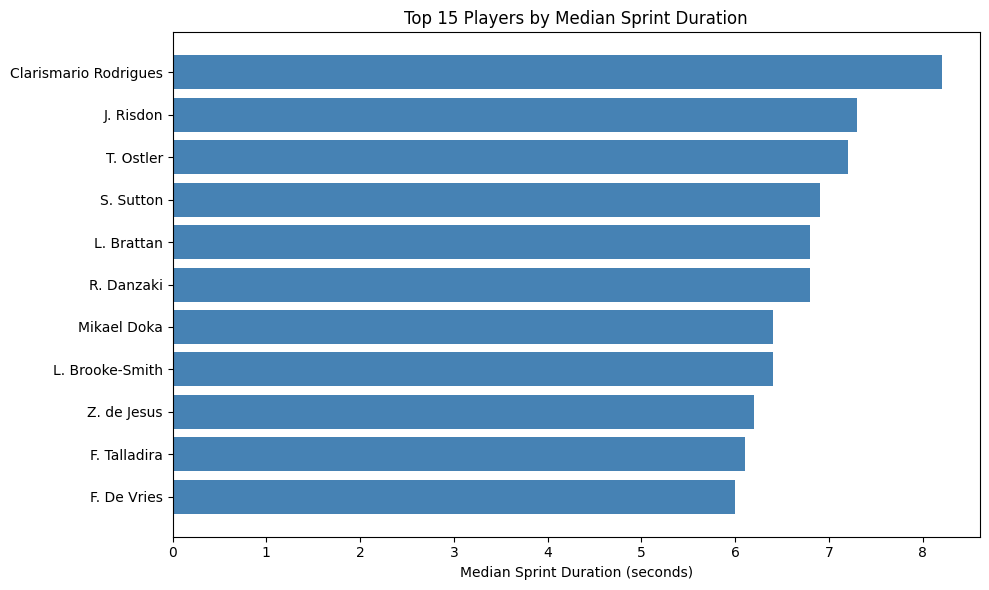

In [23]:
# ------------------------------------------------
# VISUALISATION 1: Sprint Analysis
# ------------------------------------------------
# Top 15 players by median sprint duration
top_sprinters = (
    sprints_player_combined
    .orderBy(F.desc("med_sprint_duration_secs"))
    .limit(15)
    .select("player_name", "team_shortname", "med_sprint_duration_secs")
    .toPandas()
)

plt.figure(figsize=(10, 6))
plt.barh(
    top_sprinters["player_name"],
    top_sprinters["med_sprint_duration_secs"],
    color="steelblue"
)
plt.gca().invert_yaxis()
plt.xlabel("Median Sprint Duration (seconds)")
plt.title("Top 15 Players by Median Sprint Duration")
plt.tight_layout()
plt.show()

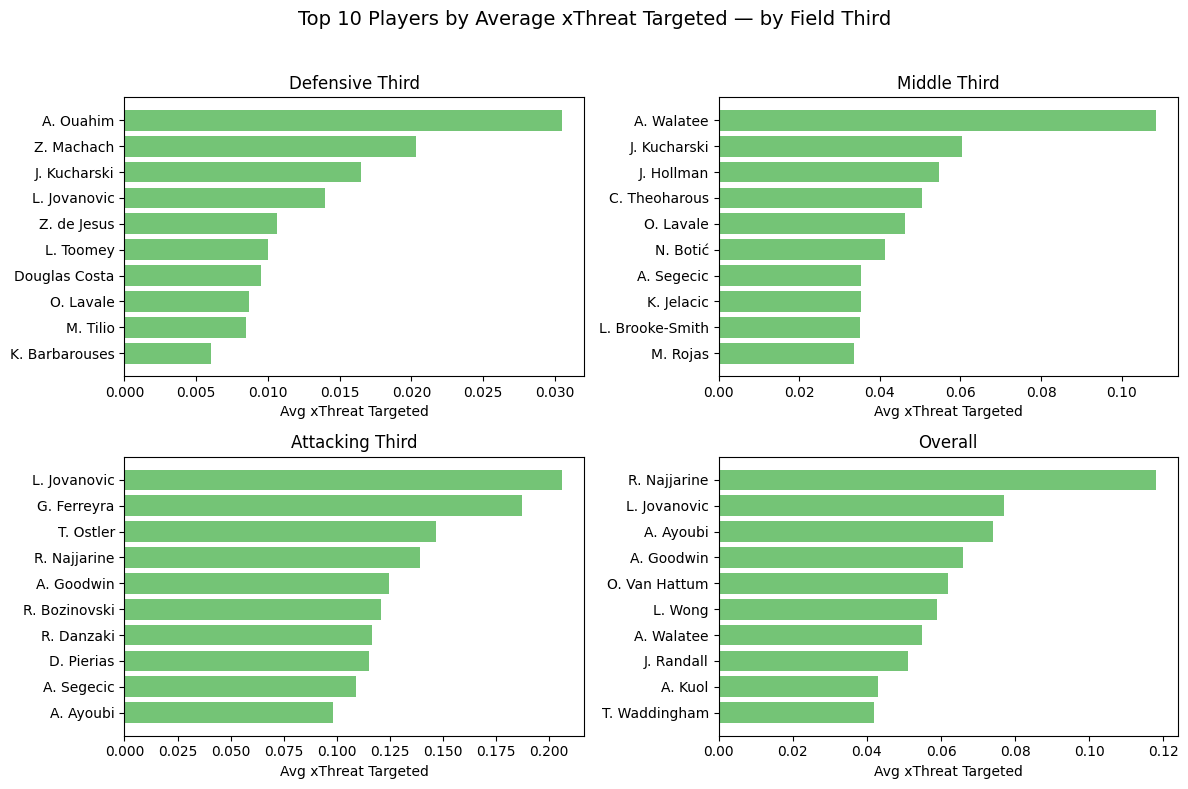

In [24]:
# ------------------------------------------------
# VISUALISATION 2: xThreat by Field Third
# ------------------------------------------------
# Prepare and clean data
xthreat_df = (
    passes_player_combined
    .filter(F.col("third_start").isNotNull())
    .select("player_name", "third_start", "avg_xthreat_targeted")
    .toPandas()
)

# Define thirds (plus overall) and create subplots
thirds = ["defensive_third", "middle_third", "attacking_third", "overall"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Generate one subplot per field third
for i, third in enumerate(thirds):
    subset = (
        xthreat_df[xthreat_df["third_start"] == third]
        .groupby("player_name", as_index=False)
        .mean(numeric_only=True)
        .sort_values("avg_xthreat_targeted", ascending=False)
        .head(10)
    )

    axes[i].barh(subset["player_name"], subset["avg_xthreat_targeted"], color="#74c476")
    axes[i].invert_yaxis()
    axes[i].set_title(third.replace("_", " ").title())
    axes[i].set_xlabel("Avg xThreat Targeted")

plt.suptitle("Top 10 Players by Average xThreat Targeted — by Field Third", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

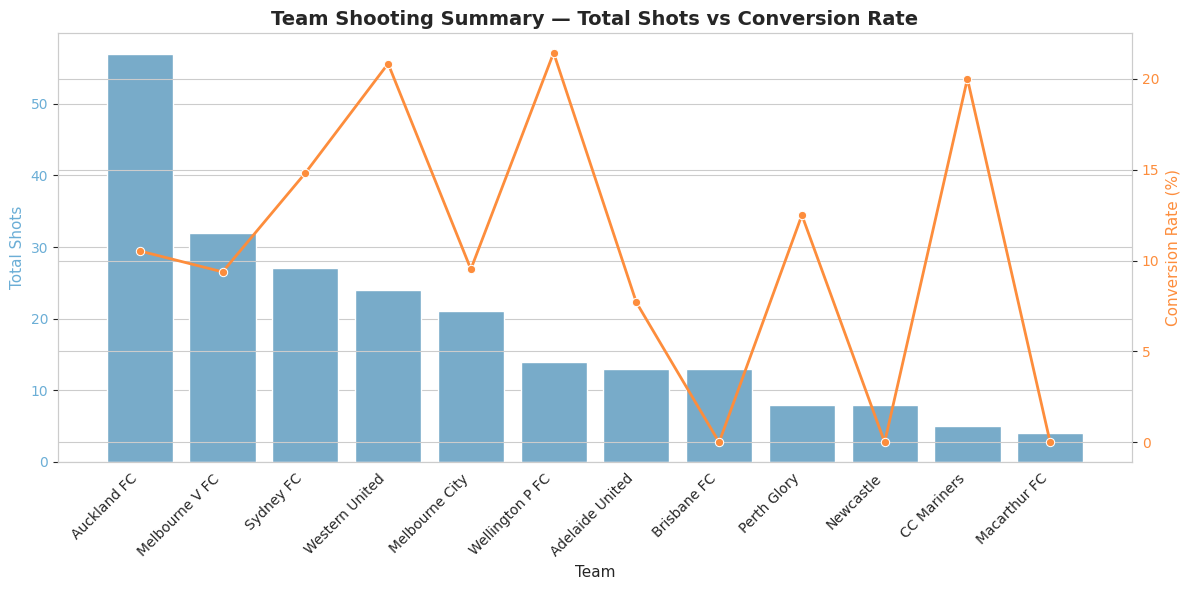

In [25]:
# ------------------------------------------------
# VISUALISATION 3: Team Shooting Summary
# ------------------------------------------------
# Convert to Pandas and aggregate to team level
pdf_shots = shots_player_summary.toPandas()
team_summary = (
    pdf_shots.groupby("team_shortname", as_index=False)
    .agg({"shots": "sum", "goals": "sum"})
)
team_summary["conversion_pct"] = (team_summary["goals"] / team_summary["shots"]) * 100
team_summary = team_summary.sort_values("shots", ascending=False)

# Plot dual-axis: shots (bars) and conversion % (line)
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar: total shots
sns.barplot(
    data=team_summary,
    x="team_shortname",
    y="shots",
    color="#6baed6",
    ax=ax1
)
ax1.set_xlabel("Team", fontsize=11)
ax1.set_ylabel("Total Shots", fontsize=11, color="#6baed6")
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Line: conversion percentage
ax2 = ax1.twinx()
sns.lineplot(
    data=team_summary,
    x="team_shortname",
    y="conversion_pct",
    color="#fd8d3c",
    marker="o",
    linewidth=2,
    ax=ax2
)
ax2.set_ylabel("Conversion Rate (%)", fontsize=11, color="#fd8d3c")

# Final layout
plt.title("Team Shooting Summary — Total Shots vs Conversion Rate", fontsize=14, weight="bold")
ax1.tick_params(axis="y", labelcolor="#6baed6")
ax2.tick_params(axis="y", labelcolor="#fd8d3c")
plt.tight_layout()
plt.show()